# Trading Signals with Adaptive SuperTrend and K-Means
This Jupyter notebook is a supplementary resource for the article.
It contains all the code snippets and examples discussed in the article,
providing a hands-on approach to understanding the concepts and techniques presented.
For a comprehensive understanding, please refer to the article at
https://entreprenerdly.com/


<p align="left">
  <img src="https://bit.ly/3FB10Z4" height=400>
</p>

# Adaptive SuperTrend and K-Means

This analysis builds a SuperTrend indicator that adapts itself to the market. The SuperTrend is a trend-following indicator. It uses the average true range to build a dynamic trailing stop.

When price closes above the stop, it signals an uptrend. When it closes below, it flips to a downtrend. The stop levels are built using a multiplier of the ATR added to or subtracted from the mid-price.

Instead of picking a fixed multiplier for the ATR bands, we test a range of values and let the data decide which one works best.

Here’s how it works:

- We calculate the SuperTrend for many different factors (1.0 to 5.0, in steps).
- For each one, we track how well it performs using a custom price-based metric.
- Then we group all the results using simple k-means clustering.
- Based on your choice ("Best", "Average", or "Worst"), we pick the right cluster and take the average factor from that group.
- Finally, we recompute the SuperTrend using that optimal factor and build a trailing stop that adjusts with price action.


## Parameters

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as mplstyle
import yfinance as yf

# User parameters
TICKER = "ASML"  # Ticker symbol to pull from Yahoo Finance

# Time range for the analysis
START_DATE = "2022-01-01"
END_DATE   = "2025-12-01"

# ATR_LENGTH controls how reactive the ATR (Average True Range) is.
# Shorter = more sensitive to price spikes. Longer = smoother.
ATR_LENGTH = 10

# These define the range of SuperTrend factors to test.
# We'll run the SuperTrend indicator across multiple values between MIN_MULT and MAX_MULT.
MIN_MULT = 1.0   # smallest factor (tightest stop)
MAX_MULT = 5.0   # largest factor (widest stop)
STEP     = 0.5   # spacing between factors (e.g., 1.0, 1.5, 2.0, ...)

# PERF_ALPHA controls smoothing of the performance metric.
# Lower = more reactive to recent price behavior.
PERF_ALPHA = 10

# We'll cluster the performance results into 3 groups (Best, Average, Worst)
# and select the factor from the chosen group.
FROM_CLUSTER = "Best"  # Options: "Best", "Average", or "Worst"

# Maximum number of iterations for the k-means clustering step
MAX_ITER = 1000

# Note: maxData isn’t needed here, but could be used to limit data length if desired.

# 1. Download Data

Historical price data for the chosen ticker (e.g., ASML) is downloaded from Yahoo Finance. Key columns (High, Low, Close) are retained, and the mid-price is computed as:  
$$
hl2 = \frac{High + Low}{2}
$$

In [ ]:

# 1) Download data
df = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d", auto_adjust=False)
if df.empty:
    raise ValueError("No data returned from yfinance")

# Flatten multi-index columns if needed
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# For safety, rename columns so we can do df["High"], etc.
df.rename(columns={"Open":"Open", "High":"High", "Low":"Low", "Close":"Close", "Volume":"Volume"}, inplace=True)

df.dropna(subset=["High","Low","Close"], inplace=True)

# hl2
df["hl2"] = (df["High"] + df["Low"]) / 2.0

[*********************100%***********************]  1 of 1 completed


# 2. Compute ATR
A 10-bar Average True Range (ATR) is calculated to measure market volatility. For each bar, the true range is computed as:  
$$
TR = \max\left(High - Low,\; |High - prev\_close|,\; |Low - prev\_close|\right)
$$  
An Exponential Moving Average (EMA) is then applied to obtain the ATR:
$$
ATR = EMA(TR, \; \text{length}=10)
$$

In [ ]:
# 2) Compute ATR
df["prev_close"] = df["Close"].shift(1)
df["tr1"] = df["High"] - df["Low"]
df["tr2"] = (df["High"] - df["prev_close"]).abs()
df["tr3"] = (df["Low"] - df["prev_close"]).abs()
df["tr"]  = df[["tr1","tr2","tr3"]].max(axis=1)
# Use EMA for ATR
df["atr"] = df["tr"].ewm(alpha=2/(ATR_LENGTH+1), adjust=False).mean()

df.dropna(inplace=True)
df.reset_index(drop=False, inplace=True)  # We'll keep a normal numeric index plus a 'Date' column
n = len(df)

# Helper: sign --> Returns +1 for up, -1 for down, 0 for no change. used to track price direction
def sign(x):
    # x > 0 => 1, x < 0 => -1, x=0 => 0
    return np.where(x>0, 1, np.where(x<0, -1, 0))

# 3. Compute SuperTrend for Each Factor
For a range of candidate factors $$f$$ (from MIN\_MULT to MAX\_MULT), the indicator calculates the upper and lower bands:
$$
up = hl2 + f \times ATR \quad \text{and} \quad dn = hl2 - f \times ATR
$$  
The trend is determined by whether the close is above the previous upper band (bullish) or below the previous lower band (bearish). A performance metric is computed using a weighted EMA of the price changes.

In [ ]:
# 3) Compute supertrend for each factor
def compute_supertrend(df, factor, perf_alpha):
    """
    For each bar:
      up = hl2 + atr * factor
      dn = hl2 - atr * factor
    We track 'trend' (1 = bullish, 0 = bearish), 'upper', 'lower', 'output', 'perf'.
    'perf' is updated with an EMA of sign-based price changes.
    """
    arr_close = df["Close"].values
    arr_hl2   = df["hl2"].values
    arr_atr   = df["atr"].values

    trend  = np.zeros(n, dtype=int)
    upper  = np.zeros(n, dtype=float)
    lower  = np.zeros(n, dtype=float)
    output = np.zeros(n, dtype=float)
    perf   = np.zeros(n, dtype=float)

    # Init
    trend[0]  = 1 if arr_close[0] > arr_hl2[0] else 0
    upper[0]  = arr_hl2[0]
    lower[0]  = arr_hl2[0]
    output[0] = arr_hl2[0]
    perf[0]   = 0.0

    for i in range(1, n):
        up = arr_hl2[i] + arr_atr[i]*factor
        dn = arr_hl2[i] - arr_atr[i]*factor

        # Determine new trend
        if arr_close[i] > upper[i-1]:
            trend[i] = 1
        elif arr_close[i] < lower[i-1]:
            trend[i] = 0
        else:
            trend[i] = trend[i-1]

        # Update upper & lower
        if arr_close[i-1] < upper[i-1]:
            upper[i] = min(up, upper[i-1])
        else:
            upper[i] = up

        if arr_close[i-1] > lower[i-1]:
            lower[i] = max(dn, lower[i-1])
        else:
            lower[i] = dn

        # Performance metric
        diff_sign = sign(arr_close[i-1] - output[i-1])
        # Weighted EMA approach
        perf[i] = perf[i-1] + 2/(perf_alpha+1)*((arr_close[i] - arr_close[i-1]) * diff_sign - perf[i-1])

        # Output
        output[i] = lower[i] if trend[i] == 1 else upper[i]

    return {
        "trend":  trend,
        "upper":  upper,
        "lower":  lower,
        "output": output,
        "perf":   perf,
        "factor": factor
    }

factors = np.arange(MIN_MULT, MAX_MULT + 0.0001, STEP)
st_results = []
for f in factors:
    st = compute_supertrend(df, f, PERF_ALPHA)
    st_results.append(st)

# We'll cluster using the final performance value
perf_vals = np.array([res["perf"][-1] for res in st_results])
fact_vals = np.array([res["factor"]     for res in st_results])

# 4. K-means Clustering
The final performance metric for each factor is clustered into three groups (Best, Average, Worst) using k-means clustering (with $$k=3$$). The cluster corresponding to the chosen category (e.g., "Best") determines the target factor for the SuperTrend indicator.

In [ ]:
# 4) K-means clustering (k=3)
def k_means(data, factors, k=3, max_iter=1000):
    # Initialize centroids from quartiles
    c1, c2, c3 = np.percentile(data, [25, 50, 75])
    centroids = np.array([c1, c2, c3])

    for _ in range(max_iter):
        clusters = {0: [], 1: [], 2: []}
        cluster_factors = {0: [], 1: [], 2: []}

        # Assign each data point
        for d, f in zip(data, factors):
            dist = np.abs(d - centroids)
            idx = dist.argmin()
            clusters[idx].append(d)
            cluster_factors[idx].append(f)

        # Recompute centroids
        new_centroids = np.array([np.mean(clusters[i]) if len(clusters[i])>0 else centroids[i]
                                  for i in range(k)])
        # Check if converged
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids

    return clusters, cluster_factors, centroids

clusters, cluster_factors, centroids = k_means(perf_vals, fact_vals, k=3, max_iter=MAX_ITER)

# Sort clusters by centroid
order = np.argsort(centroids)
sorted_clusters = {i: clusters[j] for i,j in enumerate(order)}
sorted_cluster_factors = {i: cluster_factors[j] for i,j in enumerate(order)}
sorted_centroids = centroids[order]

# 'Best' => index 2, 'Average' => index 1, 'Worst' => index 0
if FROM_CLUSTER == "Best":
    chosen_index = 2
elif FROM_CLUSTER == "Average":
    chosen_index = 1
else:
    chosen_index = 0

if len(sorted_cluster_factors[chosen_index])>0:
    target_factor = np.mean(sorted_cluster_factors[chosen_index])
else:
    target_factor = factors[-1]

# Compute the average performance for that cluster
if len(sorted_clusters[chosen_index])>0:
    target_perf = np.mean(sorted_clusters[chosen_index])
else:
    target_perf = 0.0

# 5. Recompute Final SuperTrend with Target Factor
With the target factor, the final SuperTrend is recalculated. Trend states are updated for each bar (1 for bullish, 0 for bearish). Additionally, an adaptive moving average (AMA) is built for the trailing stop, smoothing the indicator based on recent price changes.

In [ ]:
# 5) Recompute final supertrend with target_factor
st_final = compute_supertrend(df, target_factor, PERF_ALPHA)
ts  = st_final["output"]
os  = np.zeros(n, dtype=int)  # 1 = bullish, 0 = bearish
# The logic: os = close>upper => 1, close<lower => 0, else same as prior
os[0] = 1 if df["Close"].iloc[0] > st_final["upper"][0] else 0

for i in range(1, n):
    c  = df["Close"].iloc[i]
    up = st_final["upper"][i]
    dn = st_final["lower"][i]
    if c > up:
        os[i] = 1
    elif c < dn:
        os[i] = 0
    else:
        os[i] = os[i-1]

# Build an adaptive MA for the trailing stop
den_close_diff = (df["Close"] - df["Close"].shift(1)).abs()
den = den_close_diff.ewm(alpha=2/(PERF_ALPHA+1), adjust=False).mean()
den_val = den.iloc[-1] if den.iloc[-1] != 0 else 1e-9
perf_idx = max(target_perf, 0) / den_val

perf_ama = np.zeros(n, dtype=float)
perf_ama[0] = ts[0]
for i in range(1, n):
    perf_ama[i] = perf_ama[i-1] + perf_idx*(ts[i] - perf_ama[i-1])


# 6. Plot the Results
The final chart displays the close price, the bullish and bearish trailing stop lines, and the AMA of the trailing stop. Trend change signals are marked on the chart.

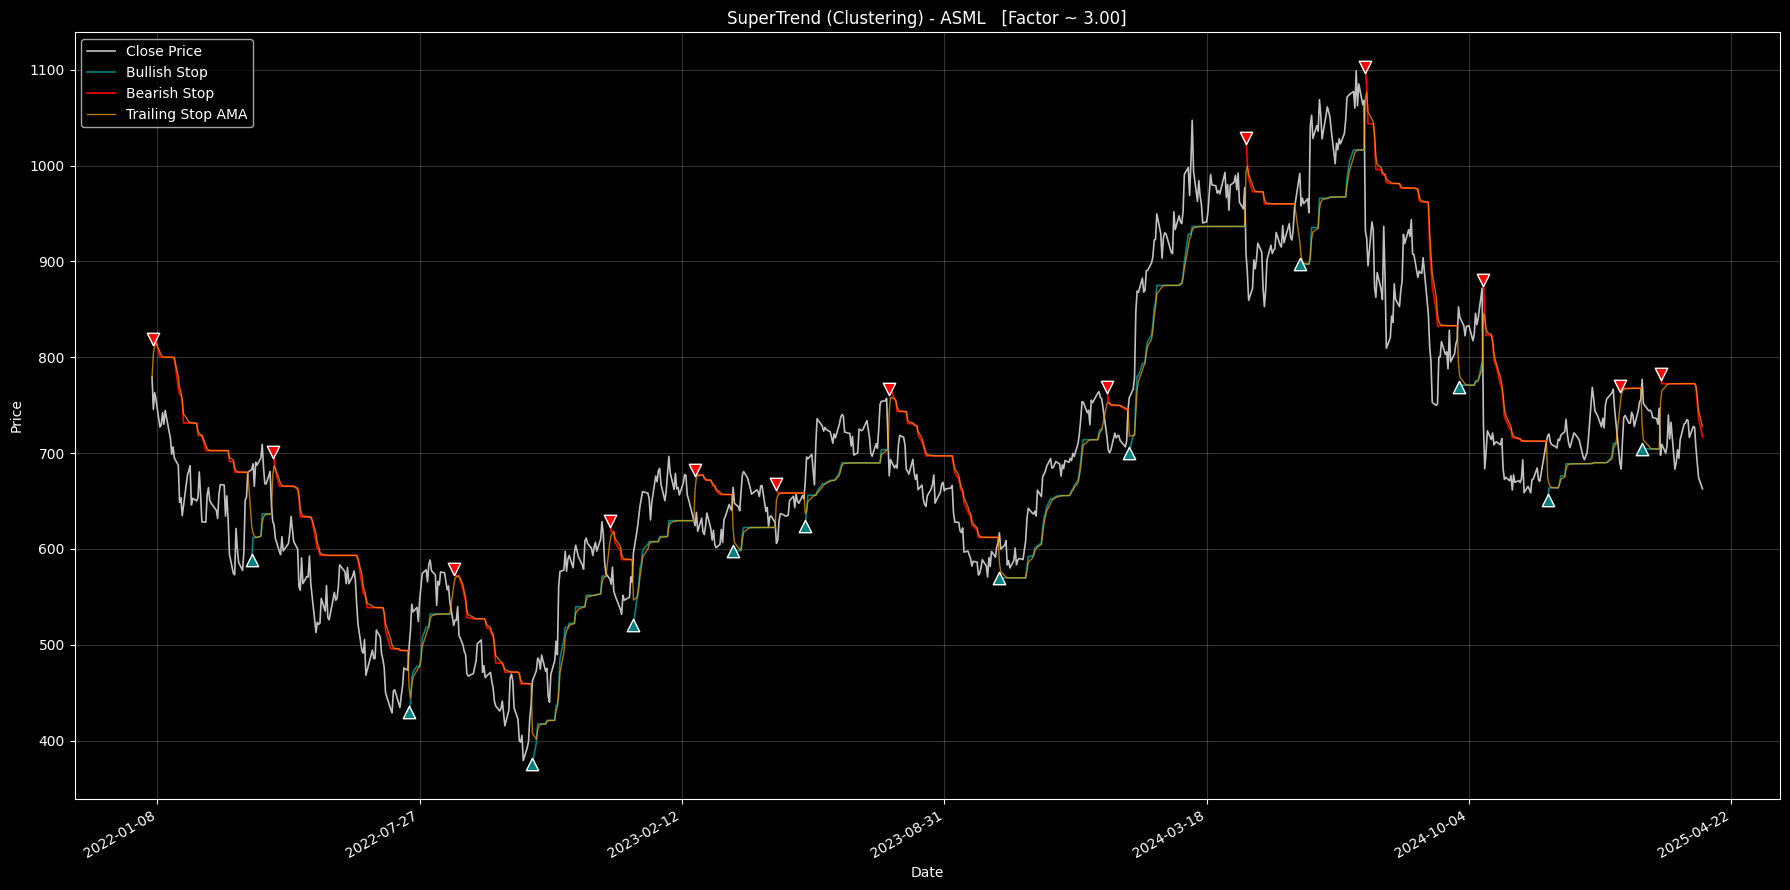

In [ ]:

# 6) Plotting
mplstyle.use("dark_background")
fig, ax = plt.subplots(figsize=(18,9))

dates = mdates.date2num(df["Date"])

# Plot close price
ax.plot(dates, df["Close"], color="silver", lw=1.2, label="Close Price")

# Build separate lines for bullish/bearish trailing stop
ts_bull = np.where(os==1, ts, np.nan)
ts_bear = np.where(os==0, ts, np.nan)

ax.plot(dates, ts_bull, color="teal", lw=1.2, label="Bullish Stop")
ax.plot(dates, ts_bear, color="red", lw=1.2, label="Bearish Stop")

# Plot AMA line
ax.plot(dates, perf_ama, color="orange", lw=1.0, alpha=0.7, label="Trailing Stop AMA")

# Plot signals where os changes
for i in range(1, n):
    if os[i] != os[i-1]:
        # If os[i] = 1 => bullish signal
        if os[i] == 1:
            ax.scatter(dates[i], ts[i], marker='^', s=80, color="teal", edgecolor="white", zorder=5)
        else:
            ax.scatter(dates[i], ts[i], marker='v', s=80, color="red", edgecolor="white", zorder=5)

ax.set_title(f"SuperTrend (Clustering) - {TICKER}   [Factor ~ {target_factor:.2f}]", color="white")
ax.set_xlabel("Date", color="white")
ax.set_ylabel("Price", color="white")
ax.legend(loc="upper left")

# Format date axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()
